# Mushrooms Identification Model with CNN

This project is based on the Kaggle mushroom identification data set:
https://www.kaggle.com/datasets/daniilonishchenko/mushrooms-images-classification-215/data

Importing all the necessary packages before we start and define all parameters.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Configurable parameters
TRAIN_DIR = './data/'  
TARGET_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 215  
EPOCHS = 50
LEARNING_RATE = 0.0001

## 1. Preprocessing

There are 3122 images in total out of the 215 species. On average each class has at around 14 images. Most classes are well balanced. The problem we are facing is just that the dataset is very small. We need to augment our data before we feed into our model. We will also need to have a test train split with our data.

In [2]:
# Data augmentation and loading
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # Specify this for validation data
)

Found 2508 images belonging to 215 classes.
Found 614 images belonging to 215 classes.


## 2. Choosing a Pre-trained Model

After testing out several different pre-trained model, VGG16 seems to be the most effective one in terms of accuracy and validated accuracy. We also customized the layers by unfreeze some layers of the base model and tune the last few layers.

In [3]:
# Load pre-trained VGG16 model without the top layer
base_model = VGG16(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Unfreeze some layers of the base model

# Fine-tuning last few layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

## 3. Adding Additional CNN Layers

In here we are adding our additional CNN layers, and this architecture was derived by a combination of examples and our own experimentation. It seems to be more efficient and have a higher accuracy compare to Conv2D & MaxPooling2D.

In [4]:
# Create new model on top of the pre-trained base
model = Sequential([
    base_model,
    Flatten(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

## 4. Choosing an Optimizer

In [5]:
from tensorflow.keras.metrics import Precision, Recall, AUC, MeanAbsoluteError
# Compile model with a smaller learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy', Precision(), Recall(), AUC(), MeanAbsoluteError()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (Batch  (None, 8192)              32768     
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 batch_normalization_1 (Bat  (None, 512)               2048      
 chNormalization)                                       

## 5. Fitting the model

In [6]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)

In [7]:
# Fit model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/50
79/79 [==============================] - ETA: 0s - loss: 6.6052 - accuracy: 0.0052 - precision: 0.0400 - recall: 3.9872e-04 - auc: 0.5087 - mean_absolute_error: 0.0093

C:\Users\wenta\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


79/79 [==============================] - 99s 1s/step - loss: 6.6052 - accuracy: 0.0052 - precision: 0.0400 - recall: 3.9872e-04 - auc: 0.5087 - mean_absolute_error: 0.0093 - val_loss: 5.8984 - val_accuracy: 0.0114 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5305 - val_mean_absolute_error: 0.0092 - lr: 1.0000e-04
Epoch 2/50
79/79 [==============================] - 97s 1s/step - loss: 6.1640 - accuracy: 0.0128 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5587 - mean_absolute_error: 0.0092 - val_loss: 6.5323 - val_accuracy: 0.0195 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5536 - val_mean_absolute_error: 0.0092 - lr: 1.0000e-04
Epoch 3/50
79/79 [==============================] - 97s 1s/step - loss: 5.8901 - accuracy: 0.0183 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5815 - mean_absolute_error: 0.0092 - val_loss: 5.8108 - val_accuracy: 0.0098 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5963 - val_mean_ab

In [8]:
# Save the final model
model.save('mushroom_classifier_model_VGG16.h5')

## 6. Interpretations

### Accuracy vs Val_accuracy

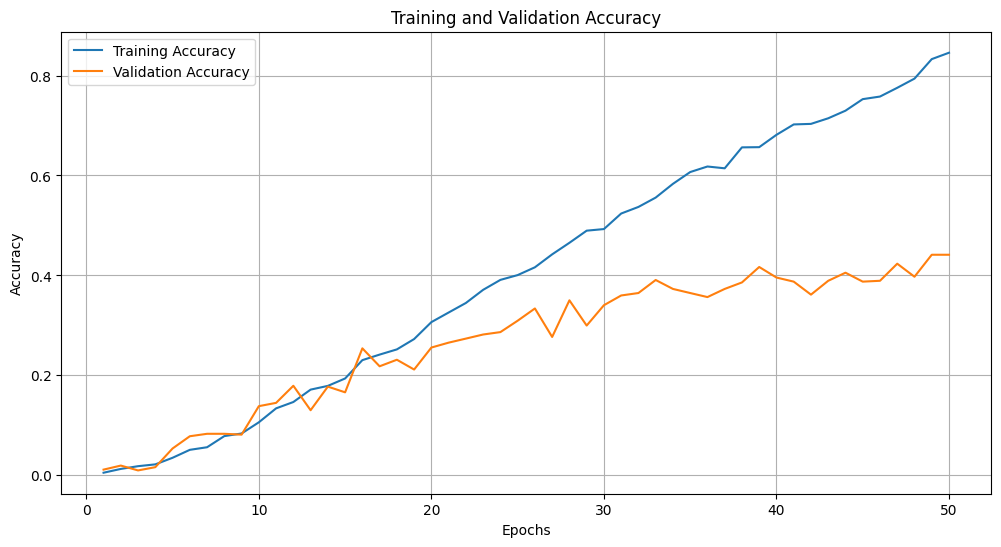

In [10]:
import matplotlib.pyplot as plt

# Accuracy data from the training output
epochs = list(range(1, 51))
accuracy = [
    0.0052, 0.0128, 0.0183, 0.0219, 0.0351, 0.0510, 0.0562, 0.0785, 0.0837, 0.1061, 
    0.1340, 0.1467, 0.1715, 0.1790, 0.1938, 0.2305, 0.2416, 0.2520, 0.2727, 0.3066,
    0.3258, 0.3449, 0.3712, 0.3911, 0.4007, 0.4163, 0.4422, 0.4653, 0.4896, 0.4928,
    0.5239, 0.5371, 0.5558, 0.5833, 0.6069, 0.6180, 0.6144, 0.6563, 0.6567, 0.6814,
    0.7022, 0.7033, 0.7145, 0.7297, 0.7528, 0.7580, 0.7755, 0.7939, 0.8329, 0.8457
]
val_accuracy = [
    0.0114, 0.0195, 0.0098, 0.0163, 0.0537, 0.0782, 0.0831, 0.0831, 0.0814, 0.1384,
    0.1450, 0.1792, 0.1303, 0.1775, 0.1661, 0.2541, 0.2182, 0.2313, 0.2117, 0.2557,
    0.2655, 0.2736, 0.2818, 0.2866, 0.3094, 0.3339, 0.2769, 0.3502, 0.2997, 0.3404,
    0.3599, 0.3648, 0.3909, 0.3730, 0.3648, 0.3567, 0.3730, 0.3860, 0.4169, 0.3958,
    0.3876, 0.3616, 0.3893, 0.4055, 0.3876, 0.3893, 0.4235, 0.3974, 0.4414, 0.4414
]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Loss vs Val_loss

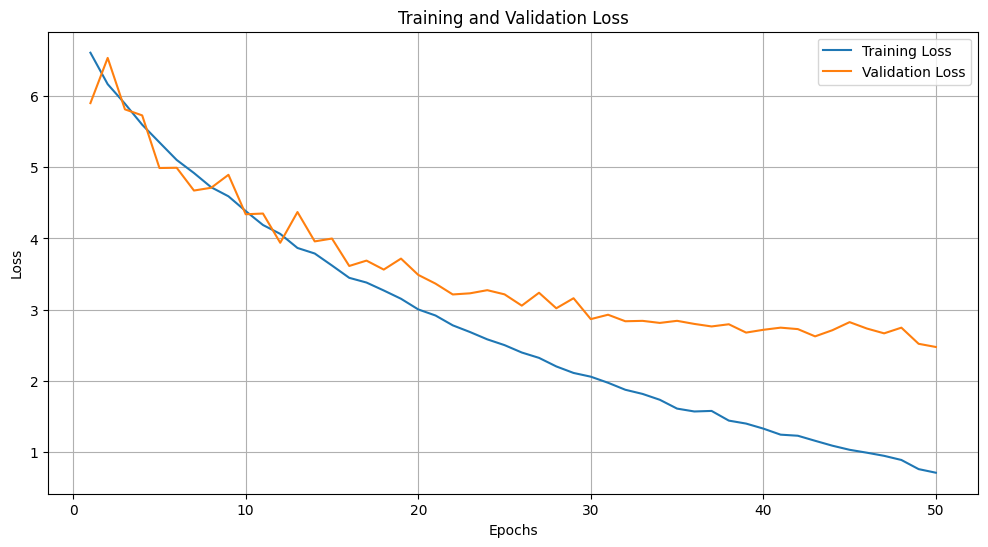

In [11]:
# Loss data from the training output
train_loss = [
    6.6052, 6.1640, 5.8901, 5.5954, 5.3473, 5.1008, 4.9179, 4.7178, 4.5910, 4.3838, 
    4.1886, 4.0641, 3.8663, 3.7886, 3.6203, 3.4475, 3.3812, 3.2701, 3.1538, 3.0042, 
    2.9190, 2.7810, 2.6870, 2.5844, 2.5035, 2.3998, 2.3245, 2.2046, 2.1132, 2.0606, 
    1.9755, 1.8773, 1.8189, 1.7367, 1.6129, 1.5726, 1.5804, 1.4445, 1.4029, 1.3323, 
    1.2475, 1.2323, 1.1615, 1.0927, 1.0350, 0.9944, 0.9504, 0.8924, 0.7640, 0.7135
]
val_loss = [
    5.8984, 6.5323, 5.8108, 5.7261, 4.9879, 4.9914, 4.6719, 4.7109, 4.8927, 4.3391, 
    4.3493, 3.9393, 4.3703, 3.9586, 3.9984, 3.6138, 3.6890, 3.5631, 3.7172, 3.4886, 
    3.3662, 3.2142, 3.2302, 3.2742, 3.2157, 3.0575, 3.2380, 3.0204, 3.1611, 2.8683, 
    2.9298, 2.8383, 2.8439, 2.8149, 2.8443, 2.8009, 2.7655, 2.7961, 2.6792, 2.7184, 
    2.7484, 2.7281, 2.6264, 2.7124, 2.8259, 2.7363, 2.6686, 2.7484, 2.5220, 2.4772
]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


There's a clear trend of decreasing loss (loss and val_loss) and increasing accuracy (accuracy and val_accuracy) as the epochs progress. This indicates that the model is learning and improving its predictions over time. And this is evident through the accuracy and val_accuracy. The model starts with a training accuracy of merely 0.5% and a validation accuracy of 1.14%, and it improves to a training accuracy of 84.57% and a validation accuracy of 44.14% by the end, which is over 50 epoch.

The training accuracy is significantly higher than the validation accuracy, suggesting some overfitting. However, the consistent improvement in validation accuracy and loss indicates that the model is still benefiting from the training. 

The MAE starts at 0.0093 in the first epoch and shows a decreasing trend over the epochs, indicating that the model's predictions are getting closer to the actual values.

The final reduction to 0.00005 at epoch 48-49 suggests an attempt to fine-tune the model's learning as it approaches convergence.


---

### Discussions

Overfitting is definitely the biggest issue for this model. Given the small amount of data, the risk of overfitting is very high. It fails to generalize to new, unseen data. Which is evident through the val_accuracy and our manual testing with new mushroom images.

Extracting relevant and sufficient features from a limited dataset is challenging. We were originally trying to extract individual mushroom features. But it was very difficult to implement. Pre-trained models such as VGG16 can help, but they might not capture all the nuances of the mushrooms.

With so many classes, it's challenging to ensure that the model can distinguish between them, especially if some classes are very similar to each other. For example, there are several different morel classes and they do look the same, velvet shank is very similar to 

In [1]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Configurable parameters
TRAIN_DIR = './data/'  # Replace with your training data path
TARGET_SIZE = (128, 128)
BATCH_SIZE = 32
NUM_CLASSES = 215  # Replace with your actual number of classes
EPOCHS = 50
LEARNING_RATE = 0.0001

# Assuming TRAIN_DIR and other constants are defined as during the training
# Recreate the train_datagen and train_generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # ... (other parameters as during the training)
    validation_split=0.2  # Assuming you used this during training
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'  # Make sure to use the same subset as used during training
)

# Now you have the class_indices
class_indices = train_generator.class_indices
indices_class = {v: k for k, v in class_indices.items()}

# Load the model
model = load_model('mushroom_classifier_model_VGG16.h5')


Found 2508 images belonging to 215 classes.


In [2]:
def checkProbabilities(path_img):
    img = image.load_img(path_img, target_size=(128, 128))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # Rescale the image in the same way as the training data

    # Make a prediction
    predictions = model.predict(img_array)

    num_vals = 5

    # Get the indices of the top 3 predictions
    top_n_indices = np.argsort(predictions[0])[-num_vals:][::-1]

    # Get the corresponding class names and probabilities
    top_classes = [indices_class[i] for i in top_n_indices]
    top_probabilities = predictions[0][top_n_indices]

    # Print the top 3 predictions and their probabilities
    for i in range(num_vals):
        print(f"{top_classes[i]}: {top_probabilities[i] * 100:.2f}%")

In [3]:
# Now you have the class_indices
class_indices = train_generator.class_indices
indices_class = {v: k for k, v in class_indices.items()}

# Load the model
model = load_model('mushroom_classifier_model_VGG16.h5')

In [4]:
import glob

# Set the directory path
test_dir = './test'  # replace with your folder path

# List to store the relative paths
path_imgs = []

# Find all files in the directory
for file in glob.glob(test_dir+'/*.*'):
    path_imgs.append(file)

# Print the list of relative paths

print(path_imgs)

# Load and preprocess the images
for path in path_imgs:
    checkProbabilities(path)

['./test\\chanterelle_1.png', './test\\chanterelle_2.png', './test\\chicken_of_the_woods_1.png', './test\\chicken_of_the_woods_2.png', './test\\oyster_1.png', './test\\oyster_2.png']
1/1 [==============================] - 0s 220ms/step
heath_waxcap: 24.33%
orange_peel_fungus: 12.53%
blackening_waxcap: 5.54%
scarlet_waxcap: 4.94%
stinking_dapperling: 4.86%
1/1 [==============================] - 0s 48ms/step
chanterelle: 52.14%
the_miller: 18.12%
white_saddle: 7.61%
orange_peel_fungus: 6.51%
frosted_chanterelle: 2.53%
1/1 [==============================] - 0s 47ms/step
hairy_curtain_crust: 67.81%
chicken_of_the_woods: 18.32%
blackening_polypore: 5.66%
turkey_tail: 1.96%
yellow_stagshorn: 1.63%
1/1 [==============================] - 0s 46ms/step
chicken_of_the_woods: 47.16%
blackening_polypore: 22.47%
blushing_rosette: 3.93%
morel: 3.83%
silverleaf_fungus: 2.92%
1/1 [==============================] - 0s 42ms/step
jelly_ears: 35.42%
oyster_mushroom: 33.21%
honey_fungus: 12.73%
horse_mushro

We have also downloaded several mushroom picture outside of the test/training set. The accuraccy matches with the previous output. Most of them can identify the correct mushroom within top 2 likely class. However, Chanterelle seems like to be the worst one out of the 3 classes here. It seems like there are similar classes such of the frosted_chanterelle and heath_waxcap. This indicates that the model might be struggling to distinguish between closely related or visually similar classes. 